In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

/tmp/ipykernel_290951/2080034654.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
#filenames_vis = ['fog_data_vis_clear.dat', 'fog_data_vis_ice.dat', 'fog_data_vis_mixed.dat', 'fog_data_vis_water.dat']
#filenames_ir = ['fog_data_ir_clear.dat', 'fog_data_ir_ice.dat', 'fog_data_ir_mixed.dat', 'fog_data_ir_water.dat']
filenames_vis = ['fog_data_vis_clear.dat', 'fog_data_vis_ice.dat', 'fog_data_vis_water.dat']
filenames_ir = ['fog_data_ir_clear.dat', 'fog_data_ir_ice.dat', 'fog_data_ir_water.dat']


# data_vis = []

# for filename in filenames_vis:
#   df = pd.read_csv(filename)
#   raw_data = df.to_numpy()
#   raw_data = np.array([row[0].split() for row in raw_data[41:]])
#   if len(data_vis) == 0:
#     data_vis = raw_data
#   else:
#     data_vis = np.vstack([data_vis, raw_data])

In [3]:
data_ir_vis = []

for file_ir, file_vis in zip(filenames_ir, filenames_vis):
  raw_data_ir = pd.read_csv('fog_dataset/' + file_ir).to_numpy()
  raw_data_vis = pd.read_csv('fog_dataset/' + file_vis).to_numpy()

  data_ir = np.array([row[0].split() for row in raw_data_ir[25:]])
  data_vis = np.array([row[0].split()[1:] for row in raw_data_vis[41:]])

  if len(data_ir_vis) == 0:
    data_ir_vis = np.hstack([data_ir, data_vis])
  else:
    data_ir_vis = np.vstack([data_ir_vis, np.hstack([data_ir, data_vis])])

In [4]:
features_i = np.concatenate((np.arange(4, 17), np.arange(20, 30), np.arange(31,34))) # 12 ir bands, 9 vis bands, 3 angles and pressure/temp
target_i = 30

X = np.zeros((data_ir_vis.shape[0], len(features_i)))
y = np.zeros(data_ir_vis.shape[0])

for i in range(len(data_ir_vis)):
  X[i] = data_ir_vis[i, features_i]
  y[i] = data_ir_vis[i,target_i]


# 19 Data points contains nan. Not sure why. Band 32 culprit, 8th feature
nan_i = np.where(np.isnan(X))[0]
X = np.delete(X, nan_i, axis=0)
y = np.delete(y, nan_i, axis=0)

In [5]:
from sklearn.preprocessing import StandardScaler


# Scaling features
feature_scaler = StandardScaler()
X_scaled = feature_scaler.fit_transform(X)

noise_std_dev = 1e-3  # adjust this based on your needs
X_scaled_noisy = X_scaled + np.random.normal(0, noise_std_dev, X_scaled.shape)

# Scaling target
target_scaler = StandardScaler()
y_scaled = target_scaler.fit_transform(y.reshape(-1, 1))

In [12]:
from sklearn.model_selection import train_test_split

# First split: Separate out a test set (10% of the original dataset)
#X_temp, X_test, y_temp, y_test = train_test_split(X_scaled_noisy, y_scaled, test_size=0.1, random_state=42)
X_temp, X_test, y_temp, y_test = train_test_split(X_scaled, y_scaled, test_size=(1/20), random_state=16)

# Second split: Split the remaining data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=(1/19), random_state=16)


In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# Create the model
model = RandomForestRegressor(n_estimators=100, random_state=42)

# Train the model
model.fit(X_train, y_train.ravel())

# Make predictions
predictions = model.predict(X_test)

# Evaluate 
mse = mean_squared_error(y_test, predictions)
print("Mean Squared Error:", mse)

In [13]:
# Regression
import tensorflow as tf
from keras import layers
from keras import regularizers

# Define the model
ff_model = tf.keras.Sequential([
    # Input layer with 13 features
    layers.Dense(len(features_i), activation='relu', input_shape=(len(features_i),)),

    # Hidden layers
    layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.Dropout(0.2),
    layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.Dropout(0.2),
    layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.Dropout(0.2),
    layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.Dropout(0.2),
    layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)),

    # Output layer with one unit for regression
    layers.Dense(1, activation='linear')
])

# Compile the model for regression
ff_model.compile(optimizer='adam',
              loss='mean_squared_error',
              metrics=['mean_absolute_error'])

# tf.optimizers.Adam(learning_rate=1e-3)

# Model summary
#model.summary()

In [17]:
history = ff_model.fit(X_train, y_train, epochs = 100, batch_size = 128, validation_data=(X_val, y_val))

Epoch 1/100
   1/1055 [..............................] - ETA: 8s - loss: 0.6656 - mean_absolute_error: 0.4780

1055/1055 [==============================] - 4s 4ms/step - loss: 0.6781 - mean_absolute_error: 0.4985 - val_loss: 0.6779 - val_mean_absolute_error: 0.4890
Epoch 2/100
1055/1055 [==============================] - 4s 4ms/step - loss: 0.6761 - mean_absolute_error: 0.4980 - val_loss: 0.6866 - val_mean_absolute_error: 0.4671
Epoch 3/100
1055/1055 [==============================] - 4s 4ms/step - loss: 0.6742 - mean_absolute_error: 0.4952 - val_loss: 0.6812 - val_mean_absolute_error: 0.4890
Epoch 4/100
1055/1055 [==============================] - 4s 4ms/step - loss: 0.6742 - mean_absolute_error: 0.4970 - val_loss: 0.6844 - val_mean_absolute_error: 0.4989
Epoch 5/100
1055/1055 [==============================] - 4s 4ms/step - loss: 0.6725 - mean_absolute_error: 0.4936 - val_loss: 0.6642 - val_mean_absolute_error: 0.4880
Epoch 6/100
1055/1055 [==============================] - 4s 4ms/step - loss: 0.6727 - mean_absolute_error: 0.4945 - val_loss: 0.6907 - val_mean_absolute_error: 0.4678
Epoch 7/10

In [ ]:
import tensorflow as tf
from keras.layers import Dense, Dropout, LayerNormalization
from keras.models import Model
from keras.layers import MultiHeadAttention, Input, GlobalAveragePooling1D

def transformer_encoder(inputs):
    # Multi-head self-attention
    x = MultiHeadAttention(num_heads=2, key_dim=2)(inputs, inputs)
    x = Dropout(0.1)(x)
    x = LayerNormalization(epsilon=1e-6)(x + inputs)

    # Feed-forward network
    ffn = Dense(64, activation='relu')(x)
    ffn = Dropout(0.1)(ffn)
    ffn = Dense(inputs.shape[-1])(ffn)
    output = LayerNormalization(epsilon=1e-6)(x + ffn)
    return output

def build_model(input_shape):
    inputs = Input(shape=input_shape)
    x = transformer_encoder(inputs)
    x = GlobalAveragePooling1D()(x)  # Aggregate feature representation
    outputs = Dense(1, activation='linear')(x)  # Output layer for regression

    model = Model(inputs=inputs, outputs=outputs)
    return model

# Example input shape (batch_size, sequence_length, feature_dim)
input_shape = (None, len(features_i))  # Adjust '13' based on your actual input shape
model = build_model(input_shape)

model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_absolute_error'])
model.summary()


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, None, 26)]           0         []                            
                                                                                                  
 multi_head_attention_1 (Mu  (None, None, 26)             454       ['input_2[0][0]',             
 ltiHeadAttention)                                                   'input_2[0][0]']             
                                                                                                  
 dropout_2 (Dropout)         (None, None, 26)             0         ['multi_head_attention_1[0][0]
                                                                    ']                            
                                                                                            

In [15]:
from keras.layers import Layer, Dense, Multiply, Permute, Reshape, Softmax
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense

class FeatureAttention(Layer):
    def __init__(self, **kwargs):
        super(FeatureAttention, self).__init__(**kwargs)

    def build(self, input_shape):
        # This layer learns a weight for each feature
        self.attention_weights = self.add_weight(name="att_weights",
                                                 shape=(input_shape[1], 1),
                                                 initializer='glorot_uniform',
                                                 trainable=True)
        super(FeatureAttention, self).build(input_shape)

    def call(self, inputs):
        # Apply a softmax to learn attention weights
        attention_scores = Softmax(axis=1)(self.attention_weights)
        # Repeat the attention scores for each data point in the batch
        attention_scores_repeated = tf.repeat(attention_scores, tf.shape(inputs)[0], axis=-1)
        attention_scores_repeated = tf.reshape(attention_scores_repeated, tf.shape(inputs))
        # Multiply inputs by attention scores
        weighted_inputs = Multiply()([inputs, attention_scores_repeated])
        return weighted_inputs



model = Sequential([
    FeatureAttention(input_shape=(len(features_i),)),  # Use your actual number of features
    Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    Dense(1, activation='linear')  # Output layer for regression
])

model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_absolute_error'])


In [14]:
history = model.fit(X_train, y_train, epochs = 20, batch_size = 64, validation_data=(X_val, y_val))

Epoch 1/20
   1/1875 [..............................] - ETA: 14s - loss: 0.5890 - mean_absolute_error: 0.4574

1875/1875 [==============================] - 8s 4ms/step - loss: 0.7341 - mean_absolute_error: 0.5330 - val_loss: 0.7124 - val_mean_absolute_error: 0.5419
Epoch 2/20
1875/1875 [==============================] - 7s 4ms/step - loss: 0.7271 - mean_absolute_error: 0.5294 - val_loss: 0.7298 - val_mean_absolute_error: 0.4722
Epoch 3/20
1875/1875 [==============================] - 8s 4ms/step - loss: 0.7209 - mean_absolute_error: 0.5259 - val_loss: 0.7066 - val_mean_absolute_error: 0.5034
Epoch 4/20
1875/1875 [==============================] - 8s 4ms/step - loss: 0.7154 - mean_absolute_error: 0.5240 - val_loss: 0.7091 - val_mean_absolute_error: 0.5433
Epoch 5/20
1875/1875 [==============================] - 7s 4ms/step - loss: 0.7153 - mean_absolute_error: 0.5218 - val_loss: 0.7131 - val_mean_absolute_error: 0.5001
Epoch 6/20
1875/1875 [==============================] - 8s 4ms/step - loss: 0.7115 - mean_absolute_error: 0.5203 - val_loss: 0.6889 - val_mean_absolute_error: 0.4873
Epoch 7/20
1875

KeyboardInterrupt: 

In [21]:
mse = model.evaluate(X_test, y_test)

469/469 [==============================] - 1s 3ms/step - loss: 0.6354 - mean_absolute_error: 0.4380


In [27]:
y_pred_scaled = model.predict(X_test)
y_pred_original = target_scaler.inverse_transform(y_pred_scaled)
y_test_original = target_scaler.inverse_transform(y_test)

print(np.mean(np.absolute(y_test_original - y_pred_original)))

err = y_test_original - y_pred_original

fog_i = np.where(y_test_original < 1000)[0]

fog_i_pred = np.where(y_pred_original < 1000)[0]

print(fog_i_pred)

print(y_test_original[fog_i_pred])



424/469 [==========================>...] - ETA: 0s

469/469 [==============================] - 1s 2ms/step
21705.480468013542
[2595 4278 8615]
[[2771.75]
 [ 392.36]
 [ 146.28]]


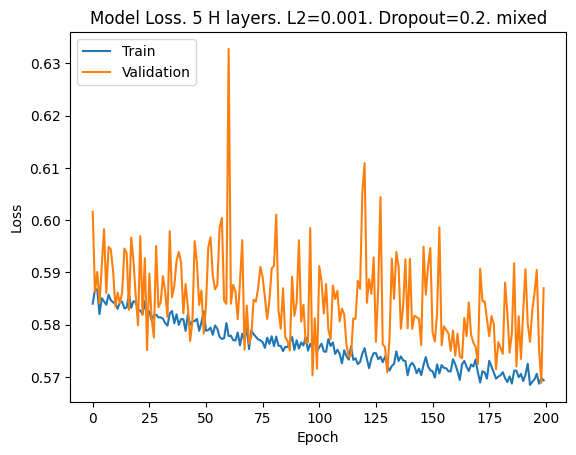

In [27]:
import matplotlib.pyplot as plt

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss. 5 H layers. L2=0.001. Dropout=0.2. mixed')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


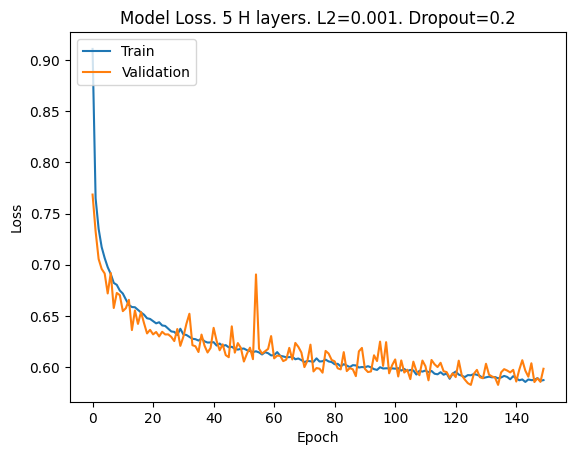

In [21]:
import matplotlib.pyplot as plt

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss. 5 H layers. L2=0.001. Dropout=0.2')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


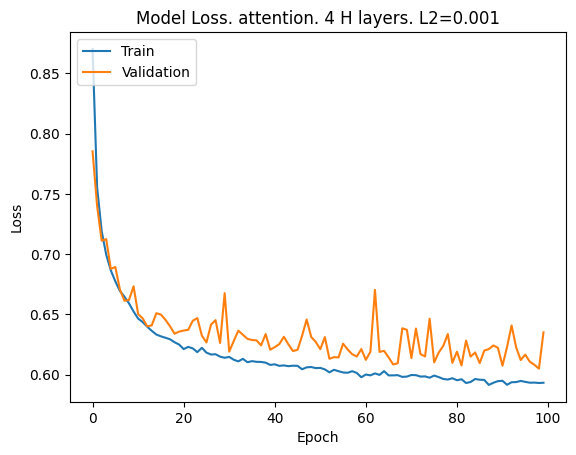

In [17]:
import matplotlib.pyplot as plt

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss. attention. 4 H layers. L2=0.001')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


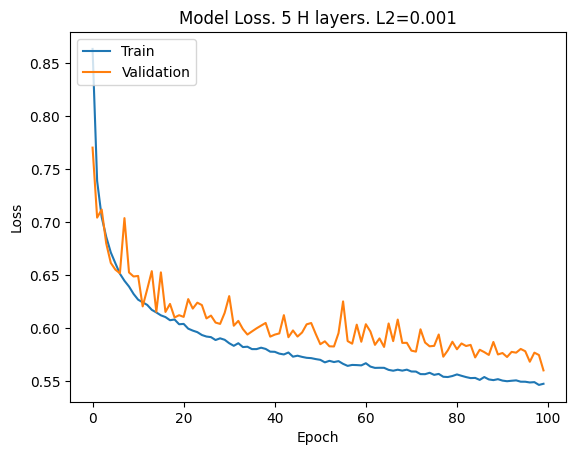

In [14]:
import matplotlib.pyplot as plt

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss. 5 H layers. L2=0.001')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


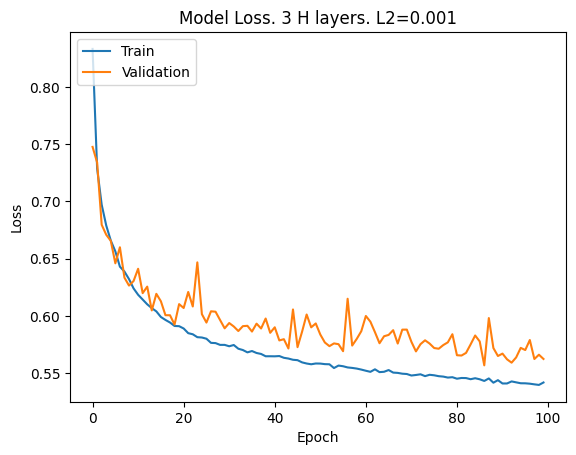

In [11]:
import matplotlib.pyplot as plt

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss. 3 H layers. L2=0.001')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


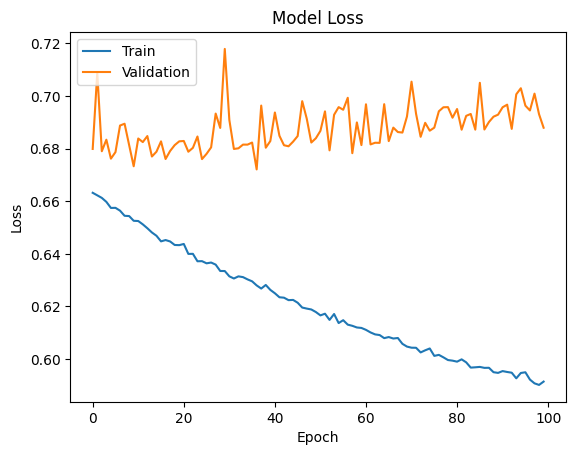

In [ ]:
import matplotlib.pyplot as plt

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


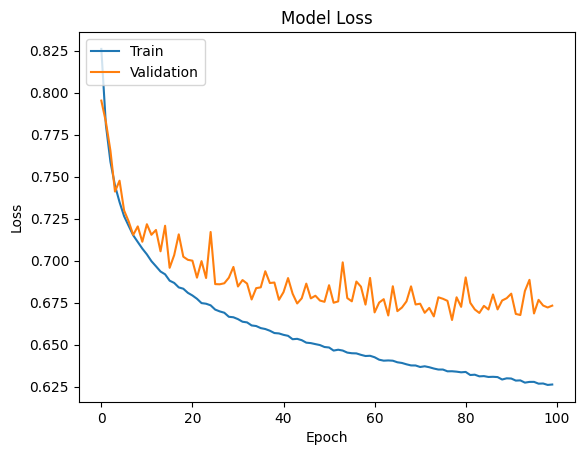

In [ ]:
import matplotlib.pyplot as plt

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


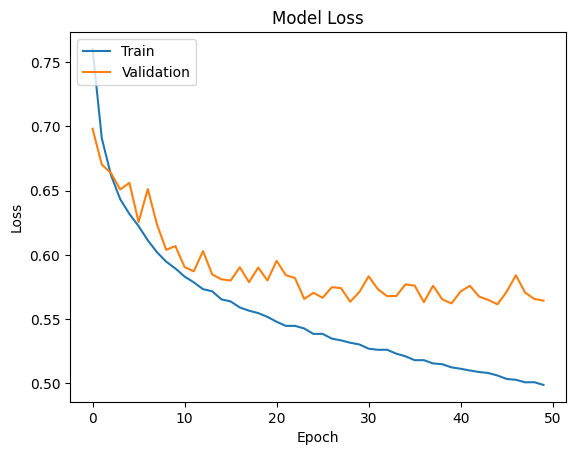

In [13]:
import matplotlib.pyplot as plt

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


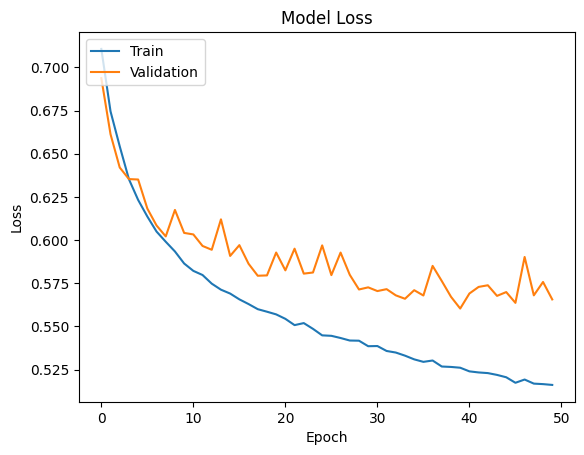

In [17]:
import matplotlib.pyplot as plt

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


In [ ]:
y_pred = model.predict(X_test)

errors = np.abs(y_test - y_pred)


print(np.mean(np.abs(errors)))

test_fog_i = np.where(y_test < 1000)[0]
print(y_pred[test_fog_i][:10])


625/625 [==============================] - 3s 5ms/step
0.5453020595642794
[[ 0.49160767]
 [ 0.16240253]
 [ 0.3813334 ]
 [-0.4462512 ]
 [ 0.0677373 ]
 [ 0.28153032]
 [ 0.31053233]
 [ 0.26071912]
 [-0.12926978]
 [-0.7308155 ]]


**Old stuff:**

In [ ]:
#Binary classification
import tensorflow as tf
from keras import layers

# Define the model
model = tf.keras.Sequential([
    # Input layer with 10 features
    layers.Dense(15, activation='relu', input_shape=(15,)),

    # Hidden layers
    layers.Dense(64, activation='relu'),

    layers.Dense(64, activation='relu'),

    # Output layer with one unit for binary classification
    layers.Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer= tf.optimizers.Adam(learning_rate=1e-3),
              loss='binary_crossentropy',
              #metrics=['accuracy'])
              metrics=[
        tf.metrics.BinaryAccuracy(),
    ],
)

# Model summary
model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 15)                240       
                                                                 
 dense_5 (Dense)             (None, 64)                1024      
                                                                 
 dense_6 (Dense)             (None, 64)                4160      
                                                                 
 dense_7 (Dense)             (None, 1)                 65        
                                                                 
Total params: 5489 (21.44 KB)
Trainable params: 5489 (21.44 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
from sklearn.metrics import confusion_matrix

y_pred = model.predict(X_test)

errors = np.abs(y_test - y_pred)

fog_indicies = np.where(y_test < 1000)[0]

print(len(fog_indicies))
print(y_pred[fog_indicies])

625/625 [==============================] - 1s 2ms/step
2540
[[ 91770.69]
 [ 78424.33]
 [ 77999.64]
 ...
 [ 55585.9 ]
 [ 78342.09]
 [119655.07]]


In [ ]:
model.fit(X_train, y_train, epochs = 10, validation_data=(X_val, y_val))

Plots

In [ ]:
#features_i = np.concatenate((np.arange(4, 17), np.arange(20, 30), np.arange(31,34))) # 12 ir bands, 9 vis bands, 3 angles

bands_ir = X[:, np.arange(0, 13)]

bands_vis = X[:, np.arange(13, 23)]
angles = X[:,np.arange(23, 26)]
visibility_classes = np.zeros_like(y)

for i in range(len(y)):
  if y[i] < 1000:
    visibility_classes[i] = 0
  elif y[i] < 10000:
    visibility_classes[i] = 1
  elif y[i] < 50000:
    visibility_classes[i] = 2
  elif y[i] < 100000:
    visibility_classes[i] = 3
  else:
    visibility_classes[i] = 4

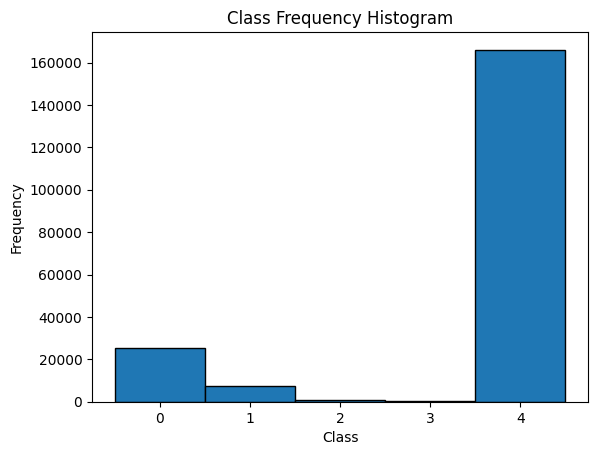

In [ ]:
plt.hist(visibility_classes, bins=np.arange(visibility_classes.min(), visibility_classes.max()+2) - 0.5, edgecolor='black')
plt.title('Class Frequency Histogram')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.xticks(np.unique(visibility_classes))
plt.show()

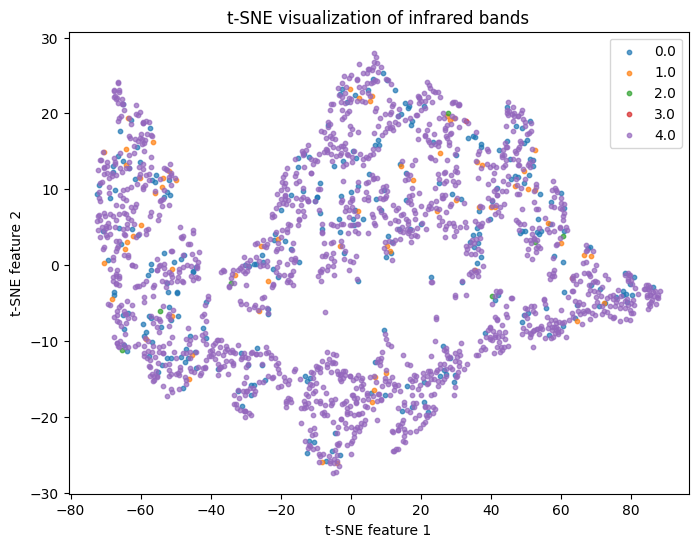

In [ ]:
from sklearn.manifold import TSNE

n_samples = 2000

# Generate n random indices
rand_i = np.random.choice(bands_ir.shape[0], n_samples, replace=False)

bands_ir_samples = bands_ir[rand_i]
class_samples = visibility_classes[rand_i]

# Apply t-SNE to reduce dimensions to 2
tsne = TSNE(n_components=2, random_state=42)
X_2d = tsne.fit_transform(bands_ir_samples)

# Create a scatter plot
plt.figure(figsize=(8, 6))
unique_labels = np.unique(class_samples)
for label in unique_labels:
    # Filter points belonging to the current label
    indices = class_samples == label
    plt.scatter(X_2d[indices, 0], X_2d[indices, 1], label=label, alpha=0.7, s=10)

# Adding aesthetics
plt.title('t-SNE visualization of infrared bands')
plt.xlabel('t-SNE feature 1')
plt.ylabel('t-SNE feature 2')
plt.legend()
plt.show()

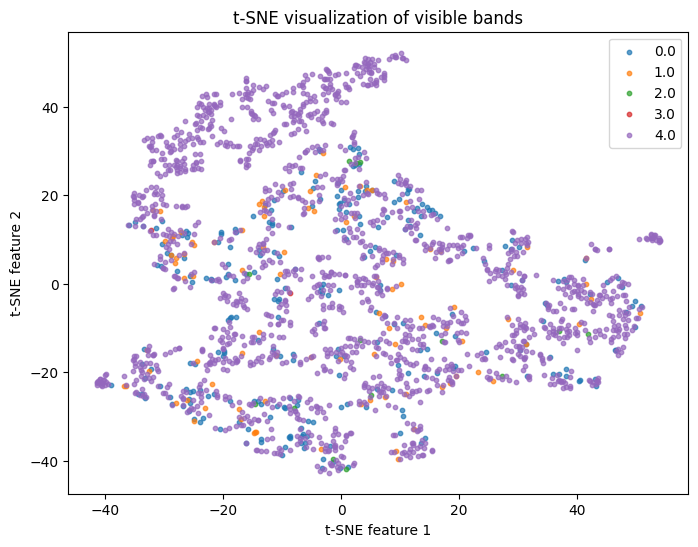

In [ ]:
from sklearn.manifold import TSNE

n_samples = 2000

# Generate n random indices
rand_i = np.random.choice(bands_vis.shape[0], n_samples, replace=False)

bands_vis_samples = bands_vis[rand_i]
class_samples = visibility_classes[rand_i]

# Apply t-SNE to reduce dimensions to 2
tsne = TSNE(n_components=2, random_state=42)
X_2d = tsne.fit_transform(bands_vis_samples)

# Create a scatter plot
plt.figure(figsize=(8, 6))
unique_labels = np.unique(class_samples)
for label in unique_labels:
    # Filter points belonging to the current label
    indices = class_samples == label
    plt.scatter(X_2d[indices, 0], X_2d[indices, 1], label=label, alpha=0.7, s=10)

# Adding aesthetics
plt.title('t-SNE visualization of visible bands')
plt.xlabel('t-SNE feature 1')
plt.ylabel('t-SNE feature 2')
plt.legend()
plt.show()

Pearson correlation coefficient: -2.864815621256506e-05
P-value: 0.9897784557925945


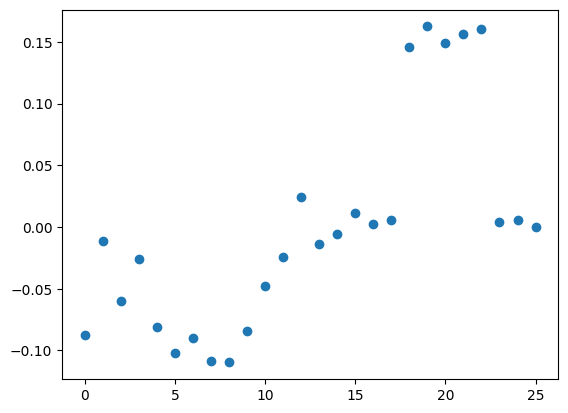

In [ ]:
#pearson number
from scipy.stats import pearsonr

correlations = np.zeros(26)
p_values = np.zeros(26)
feature2 = y_scaled.flatten()

for i in range(X_scaled.shape[1]):
  feature1 = X_scaled[:,i].flatten()
  correlation, p_value = pearsonr(feature1, feature2)
  correlations[i] = correlation
  p_values[i] = p_value

plt.scatter(range(len(correlations)),correlations)
plt.show

print("Pearson correlation coefficient:", correlation)
print("P-value:", p_value)

<function matplotlib.pyplot.show(close=None, block=None)>

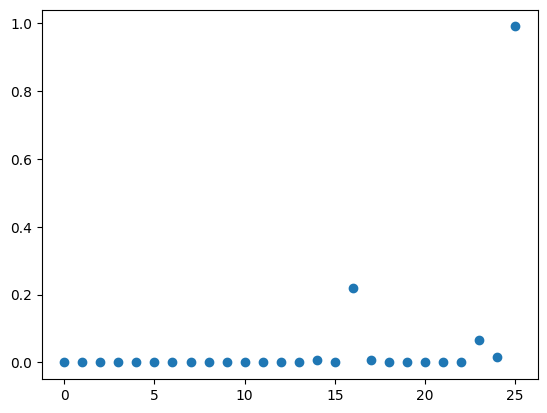

In [ ]:
plt.scatter(range(len(p_values)),p_values)
plt.show

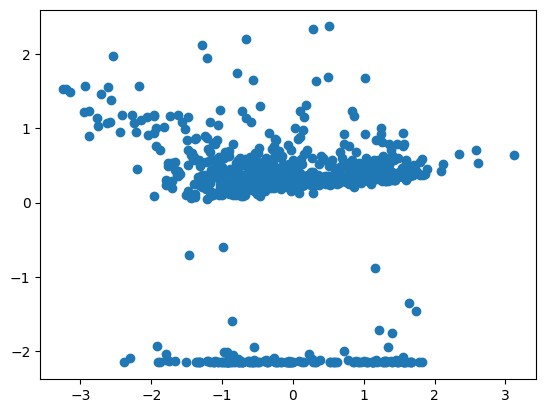

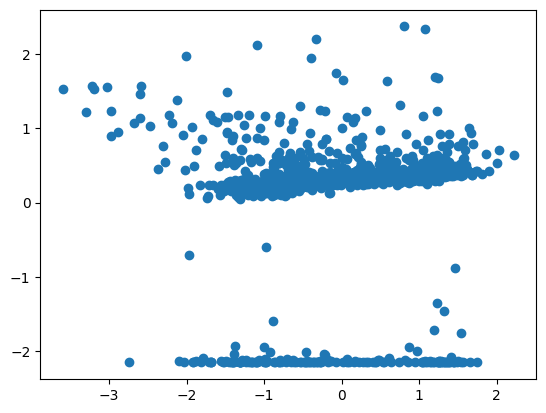

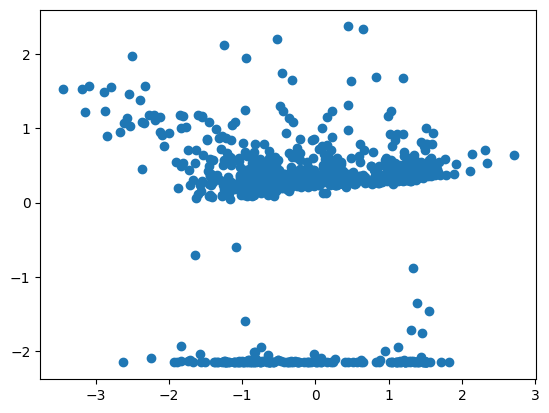

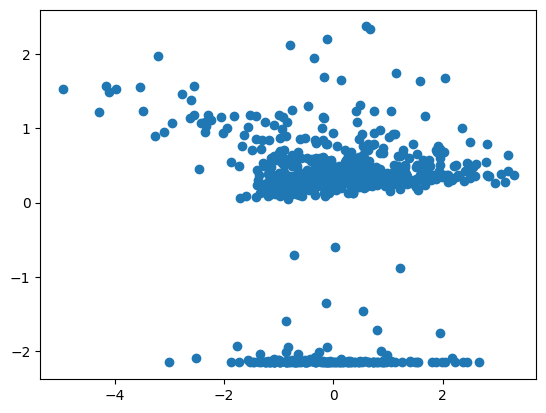

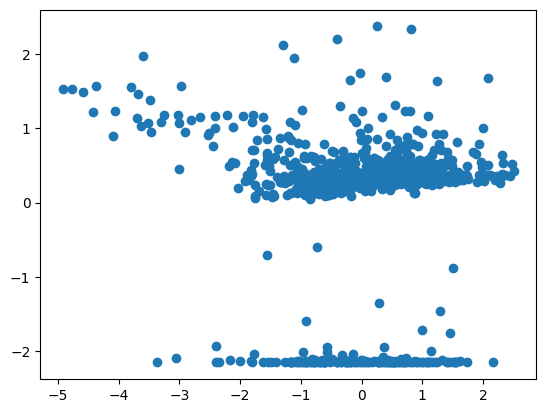

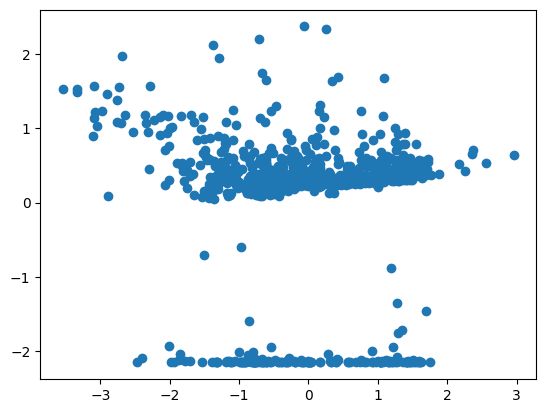

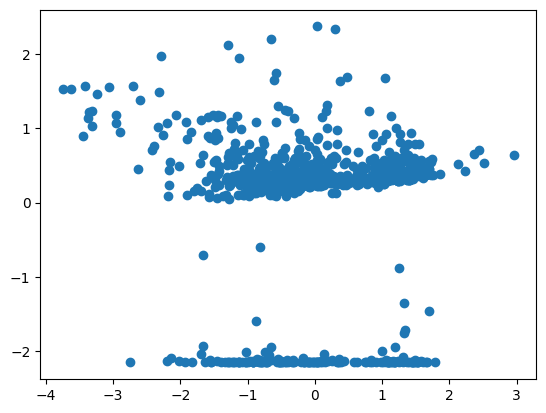

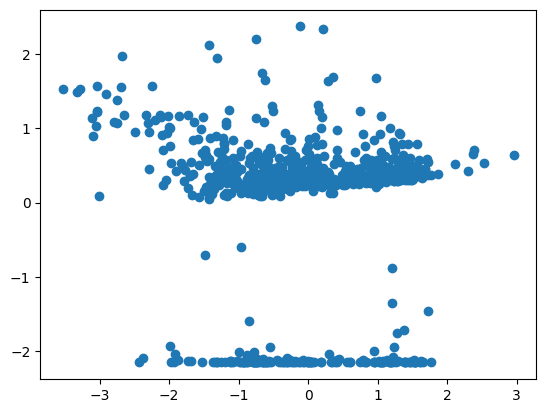

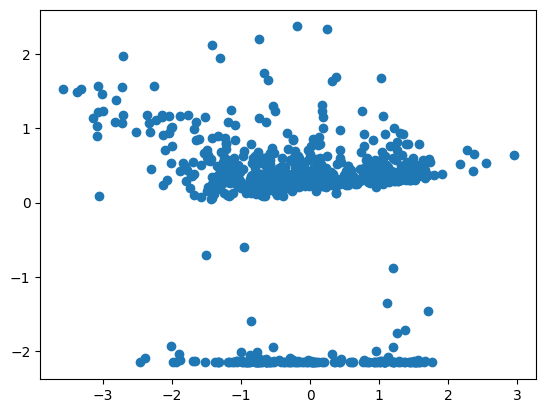

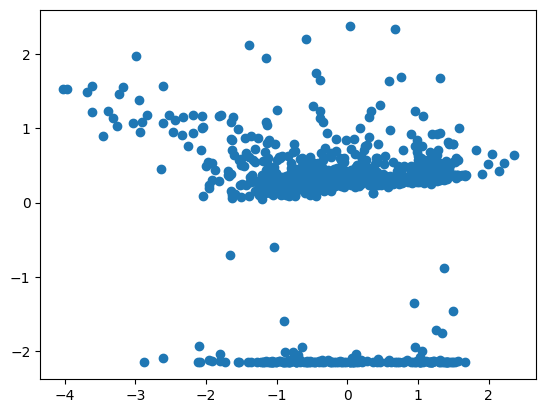

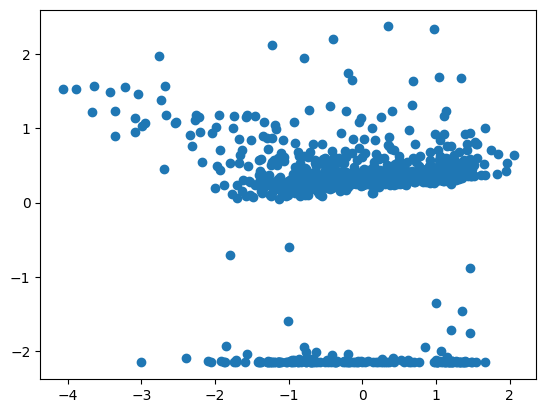

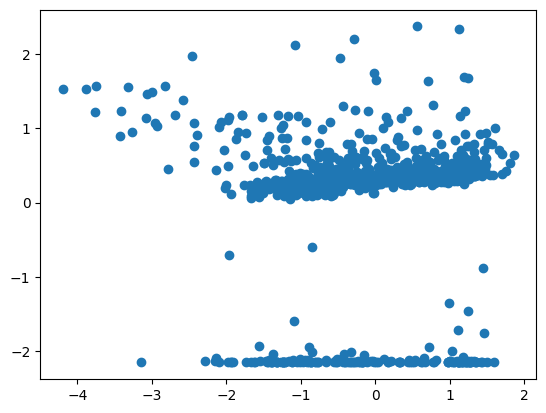

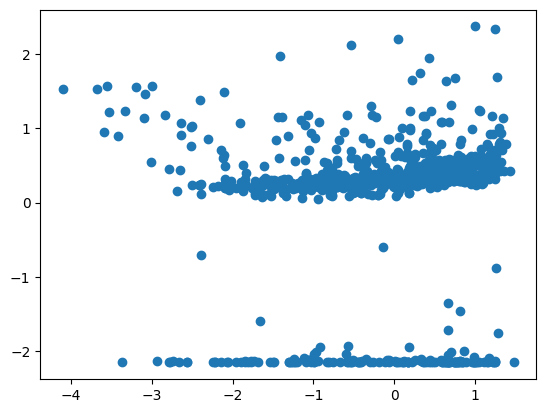

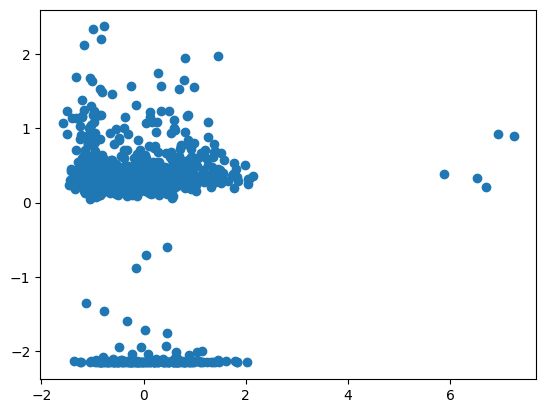

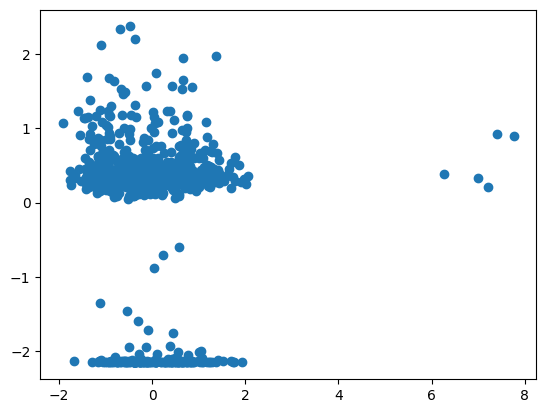

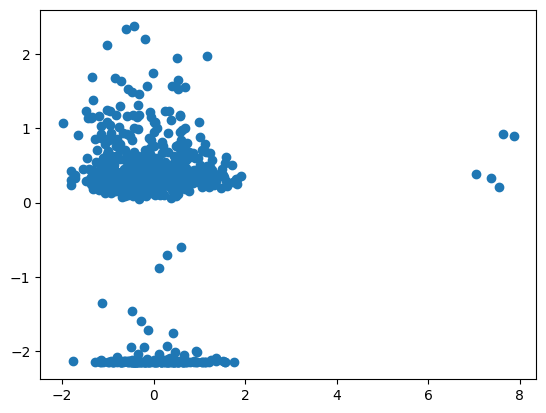

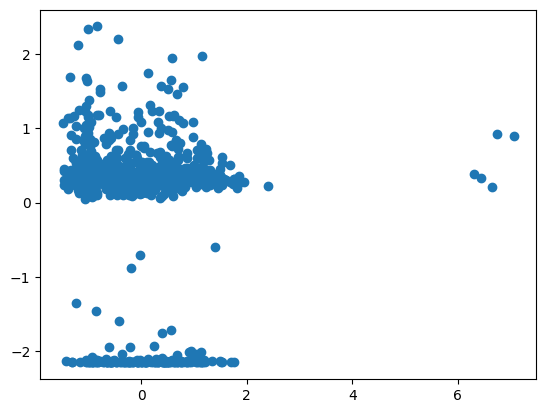

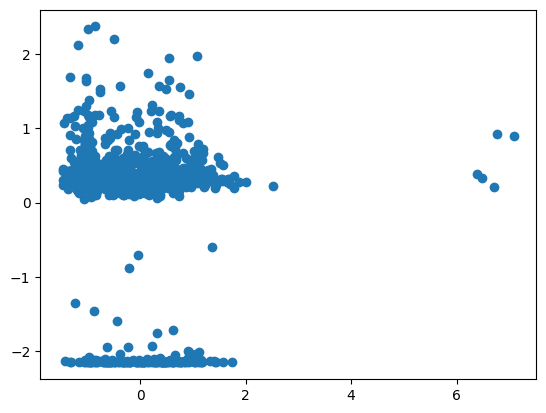

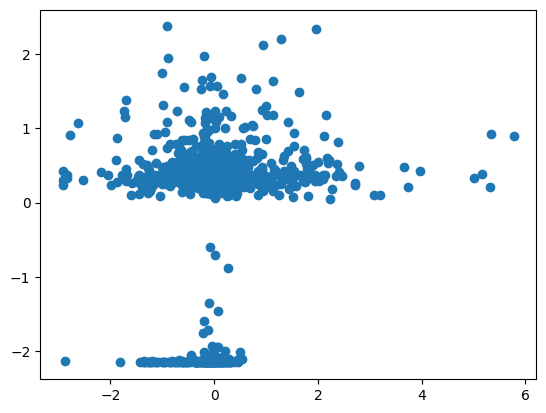

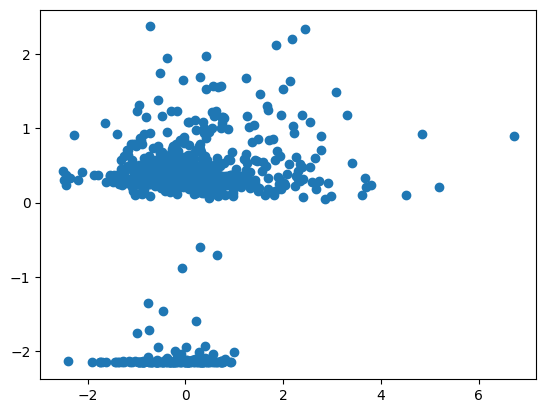

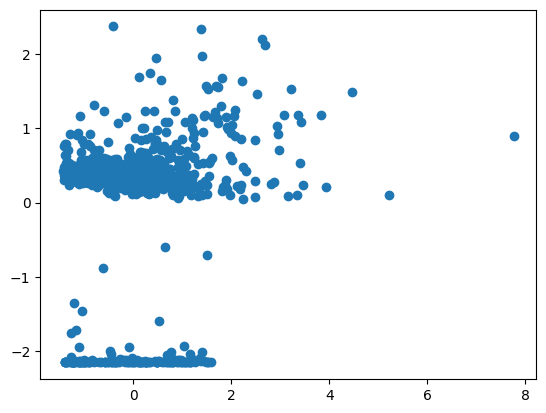

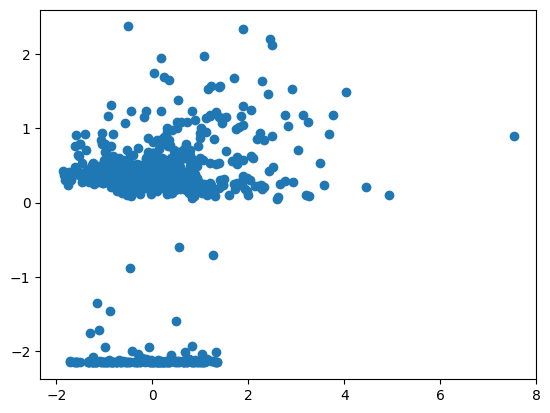

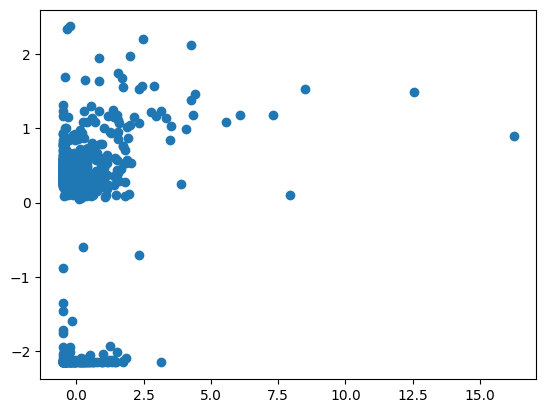

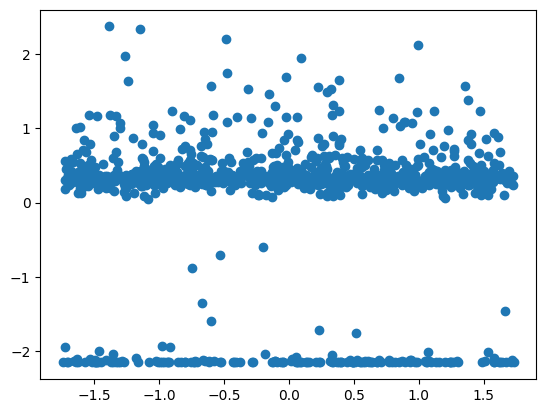

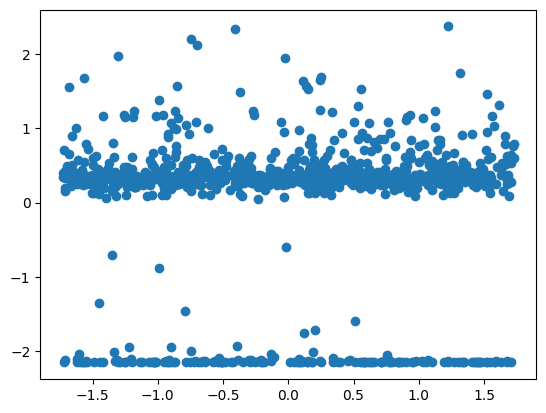

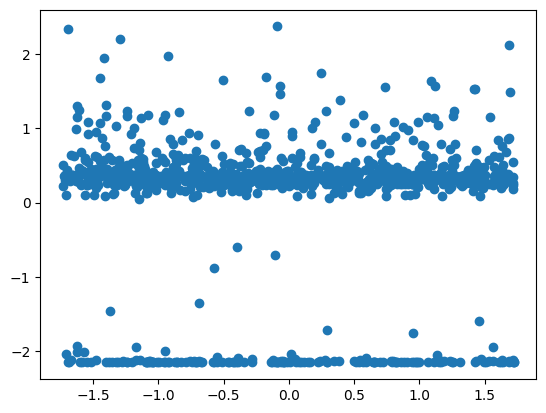

In [ ]:
n_samples = 1000
rand_i = np.random.choice(X_scaled.shape[0], n_samples, replace=False)

for i in range(X_scaled.shape[1]):
  plt.scatter(X_scaled[rand_i, i], y_scaled[rand_i])
  plt.show()


